In [16]:
import os
import time
import shutil
import pathlib
import itertools
from functools import partial
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [17]:
data_dir = './weather_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

df

,filepaths,labels
0,./weather_dataset\Cloudy\cloudy1.jpg,Cloudy
1,./weather_dataset\Cloudy\cloudy10.jpg,Cloudy
2,./weather_dataset\Cloudy\cloudy100.jpg,Cloudy
3,./weather_dataset\Cloudy\cloudy101.jpg,Cloudy
4,./weather_dataset\Cloudy\cloudy102.jpg,Cloudy
...,...,...
1120,./weather_dataset\Sunrise\sunrise95.jpg,Sunrise
1121,./weather_dataset\Sunrise\sunrise96.jpg,Sunrise
1122,./weather_dataset\Sunrise\sunrise97.jpg,Sunrise
1123,./weather_dataset\Sunrise\sunrise98.jpg,Sunrise


In [18]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [19]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.


Found 90 validated image filenames belonging to 4 classes.


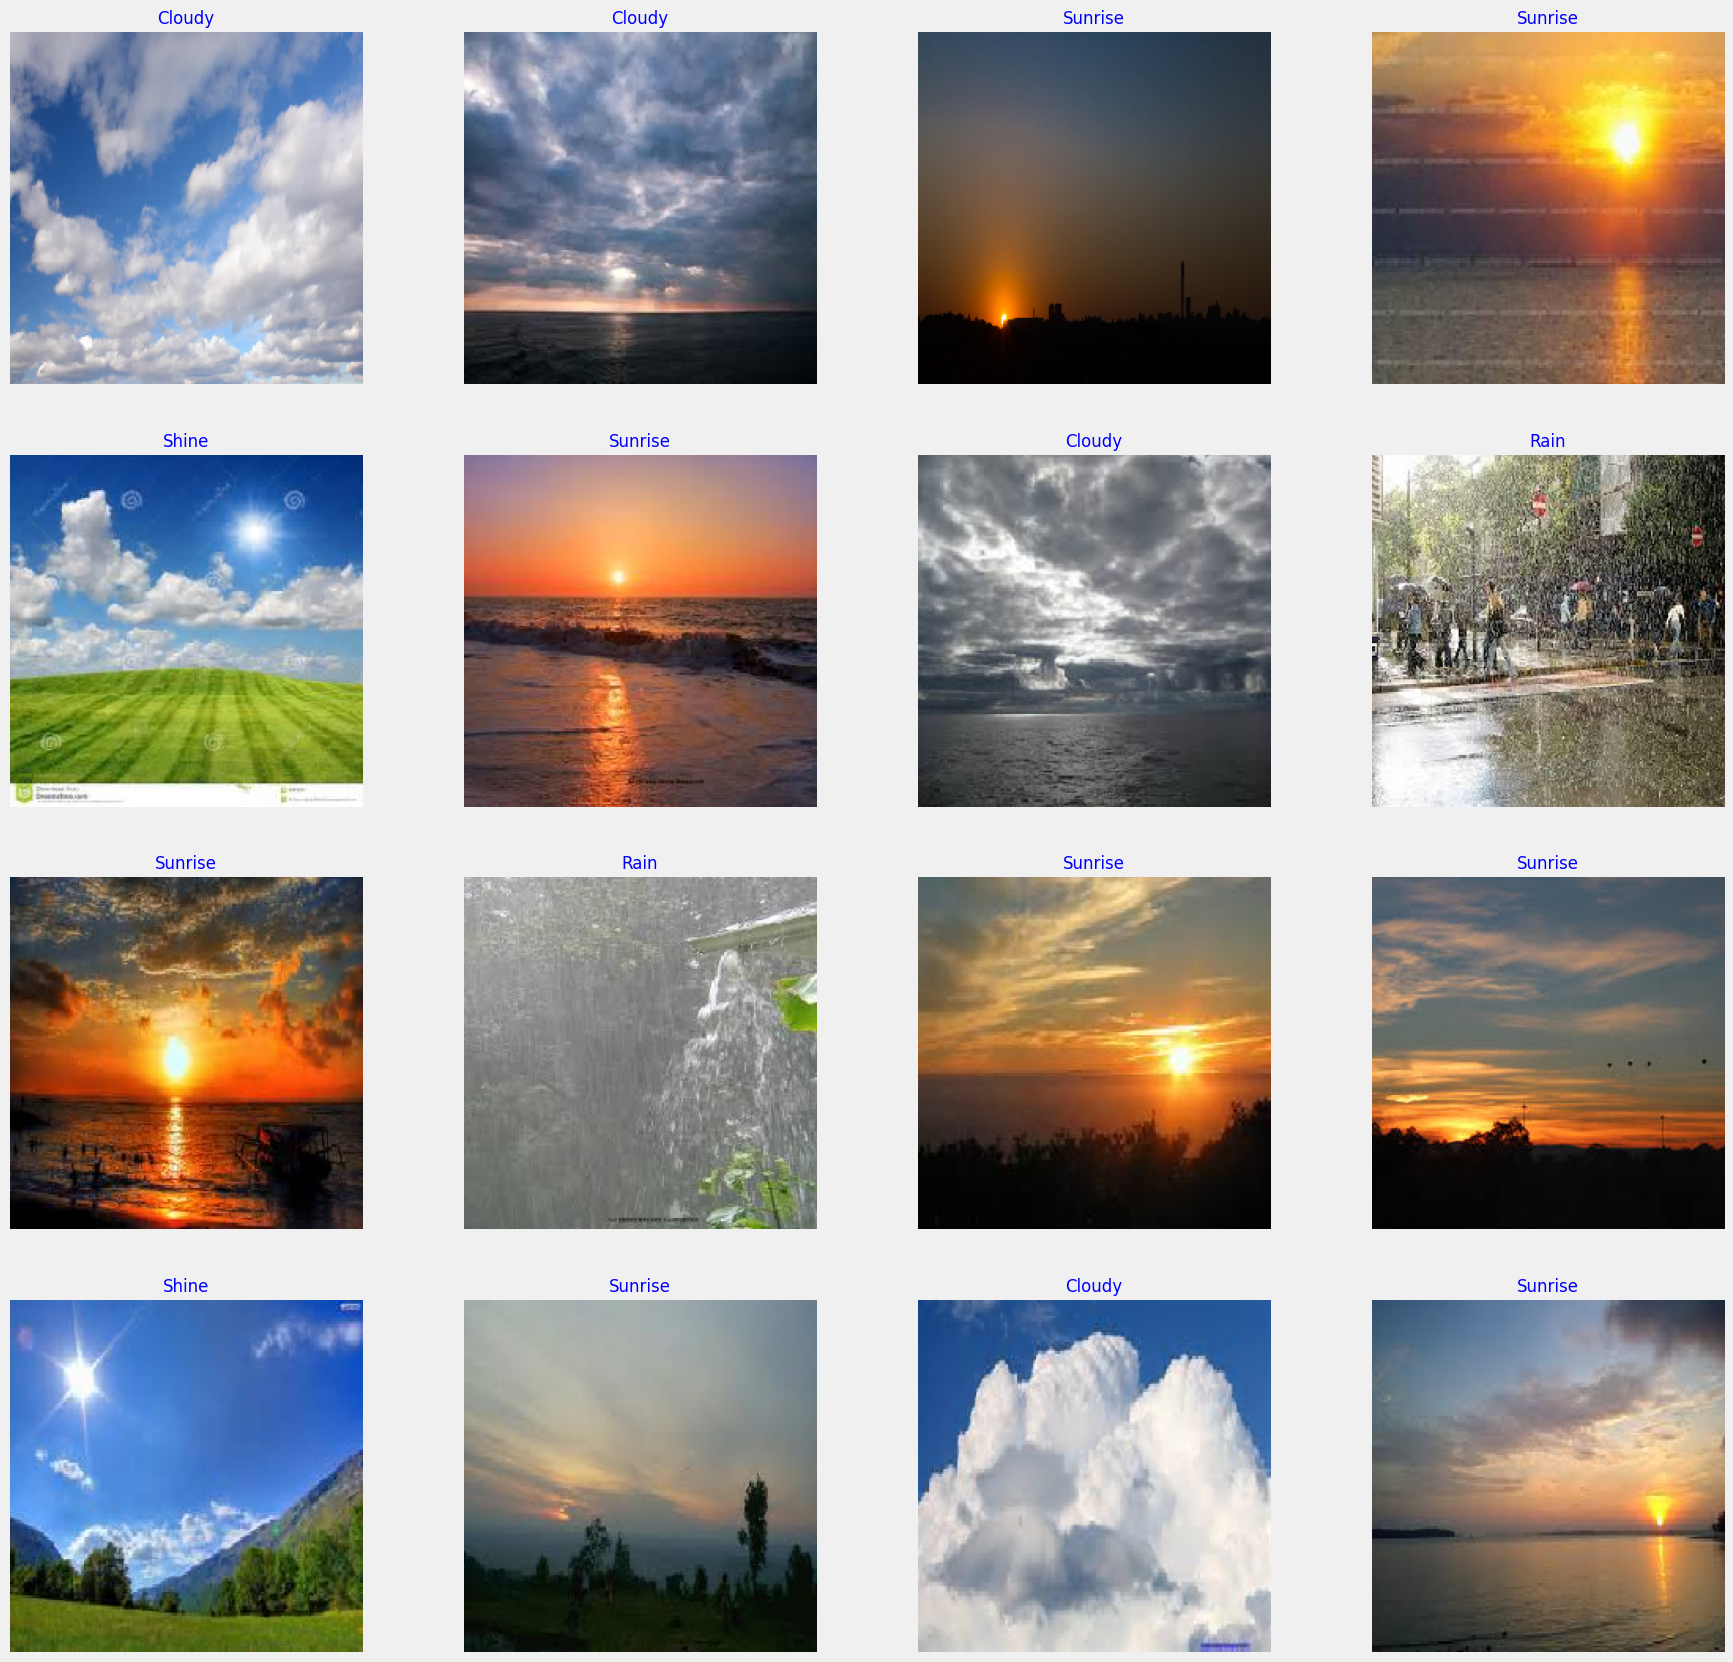

In [20]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same",
                            activation="relu", kernel_initializer="he_normal")
# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'none')
model = Sequential([
    #base_model,
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    #DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    MaxPooling2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    #MaxPooling2D(),
    Flatten(),
    Dense(units=128, activation="relu",
                        kernel_initializer="he_normal"),
    Dropout(0.5),
    Dense(units=64, activation="relu",
                        kernel_initializer="he_normal"),
    Dropout(0.5),
    Dense(class_count, activation= 'softmax')
])
    # model = Sequential()
    # model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(224, 224, 3)))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
    # model.add(Flatten())
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5)),
    # model.add(Dense(4, activation='softmax'))  # Change to 4 for your 4 classes


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                        tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0

In [23]:
from keras import backend as K
tf.keras.backend.clear_session()
K.clear_session()
epochs = 25   # number of all epochs in training
with tf.device('/device:GPU:0'):
        tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)))
        history = model.fit(x= train_gen, epochs= epochs, verbose=1, validation_data= valid_gen, validation_steps= None, shuffle= False)
        tf.keras.backend.clear_session()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1/25
 6/57 [==>...........................] - ETA: 5s - loss: 0.6823 - accuracy: 0.7188 - precision: 0.8116 - recall: 0.5833 - auc: 0.9214

KeyboardInterrupt: 

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

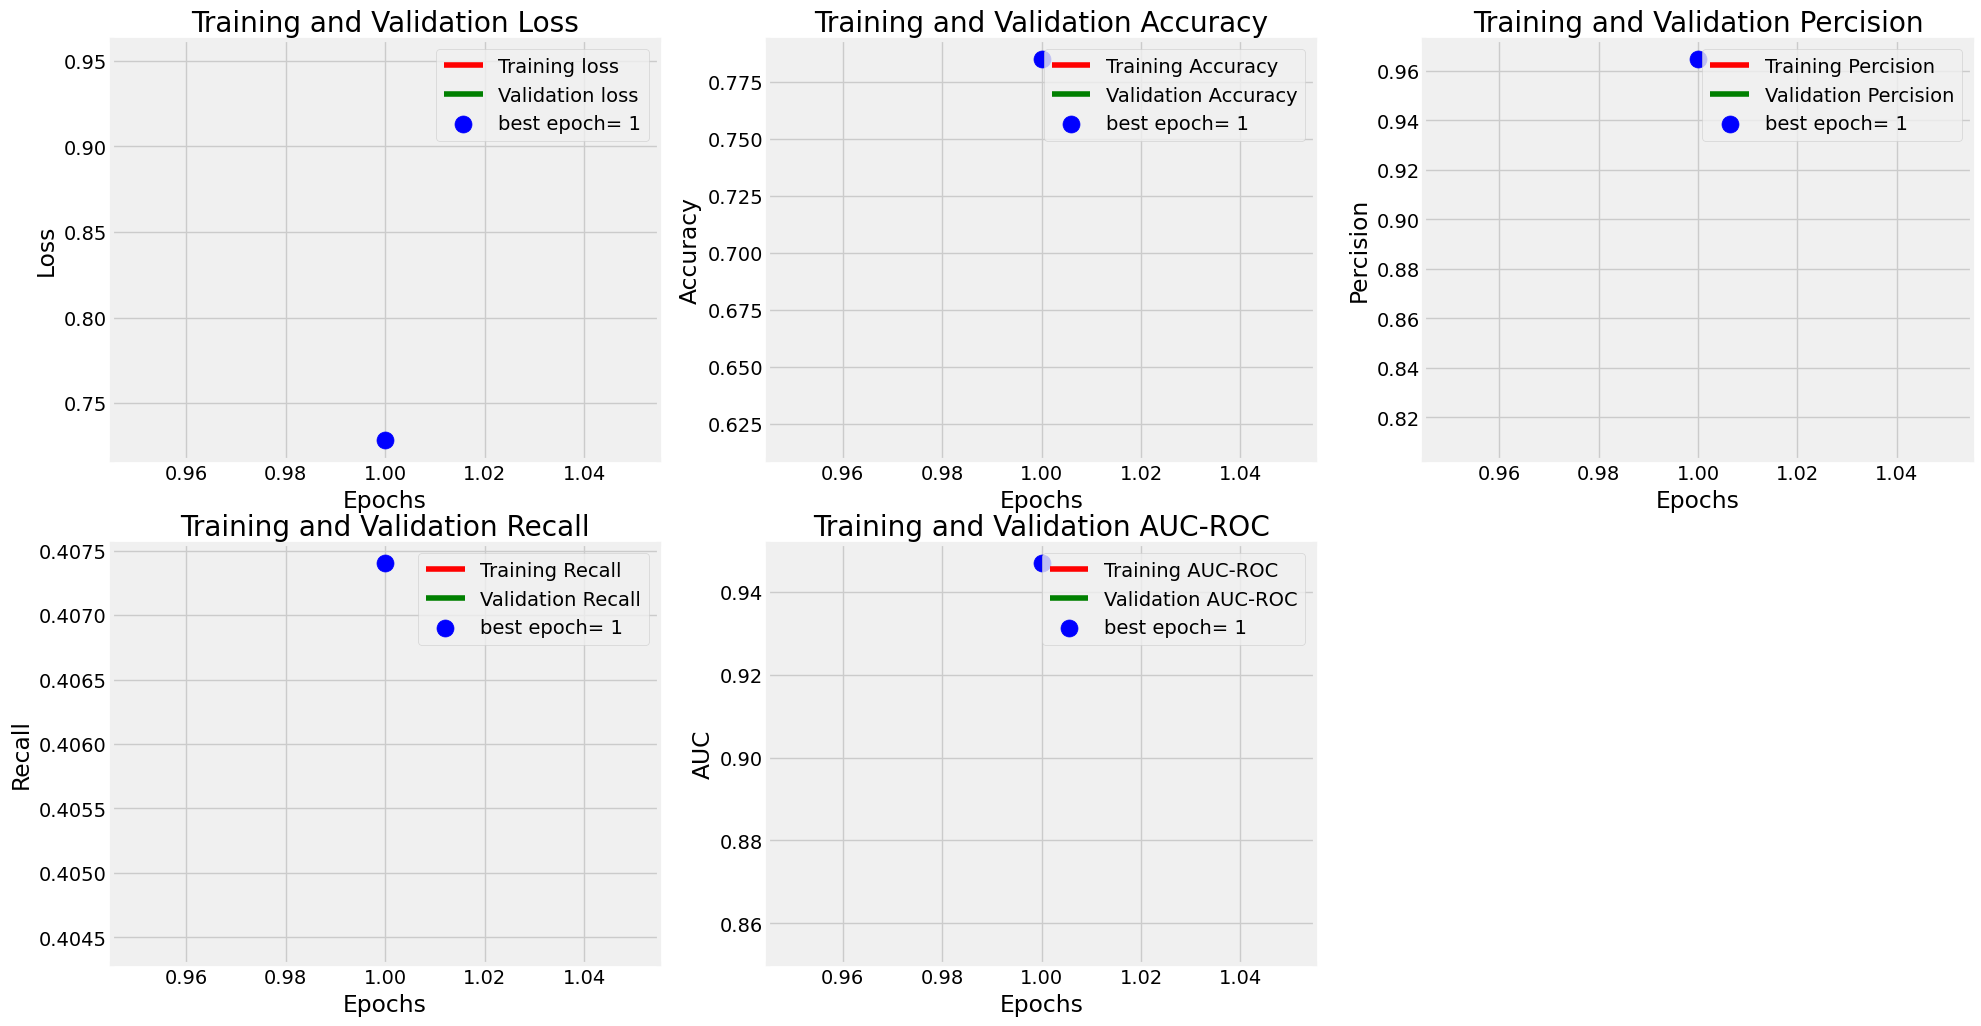

In [ ]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
\
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'blue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()
plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'blue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'blue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

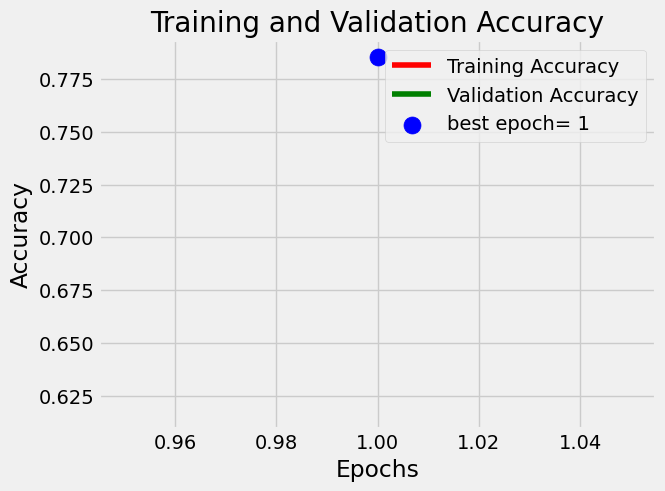

In [ ]:
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 0s 34ms/step - loss: 0.7326 - accuracy: 0.8125 - precision: 0.9444 - recall: 0.5312 - auc: 0.9318
Train Loss:  0.8425723314285278
Train Accuracy:  0.71875
--------------------
Validation Loss:  0.7850661277770996
Validation Accuracy:  0.71875
--------------------
Test Loss:  0.7326335310935974
Test Accuracy:  0.8125


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

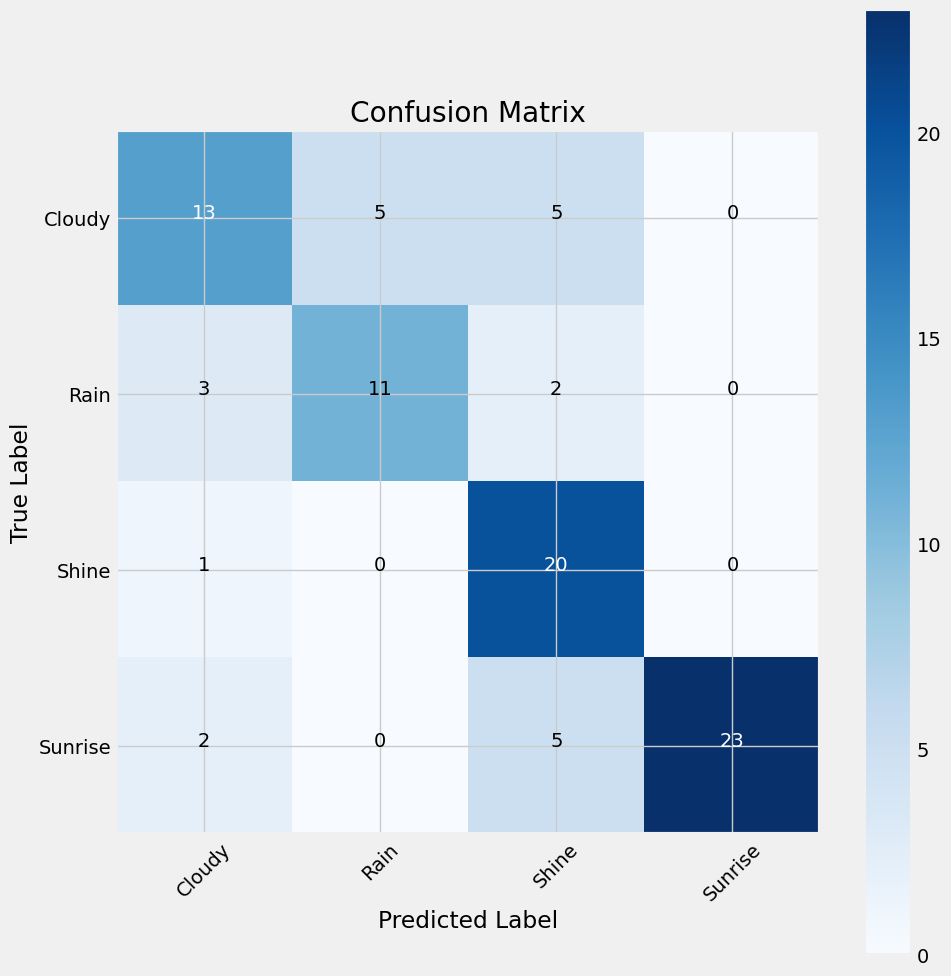

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Weather Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = './weather_dataset/Rain.rain1.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Cloudy', 'Rain','Shine','Sunrise']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")